In [50]:
#Import all the necessary Library 
import torchvision
import torch.utils.data as utils
from sympy.codegen import Print
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import kagglehub
import shutil
import os

In [51]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
                 bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [52]:
## Download latest version
## Download dataset (default location)
#default_path = kagglehub.dataset_download("robinreni/signature-verification-dataset")
#
## Define the target directory
#target_path = r"A:\3rd_Year_Project\Project_code\data"#
#
## Ensure the target directory exists
#os.makedirs(target_path, exist_ok=True)
#
## Move the dataset to the target directory
#shutil.move(default_path, target_path)
#
#print("Dataset moved to:", target_path)

In [146]:
class Config():
    training_dir = "A:/3rd_Year_Project/Project_code/data/2/sign_data/sign_data/train"
    testing_dir = "A:/3rd_Year_Project/Project_code/data/2/input/sign_data/sign_data/test"
    train_batch_size = 32 #originally 32
    train_number_epochs = 20 #originally 20

In [147]:
training_dir="A:\\3rd_Year_Project\\Project_code\\data\\2\\sign_data\\sign_data\\train"
training_csv = r"A:\3rd_Year_Project\Project_code\data\2\sign_data\train_data.csv"
testing_csv="A:\\3rd_Year_Project\\Project_code\\data\\2\\sign_data/sign_data/test_data.csv"
testing_dir="A:\\3rd_Year_Project\\Project_code\\data\\2/sign_data/sign_data/test"

In [148]:
class SiameseNetworkDataset():

    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns =["image1","image2","label"]
        self.training_dir = training_dir
        self.transform = transform

    def __getitem__(self,index):

        # getting the image path
        image1_path=os.path.join(self.training_dir,self.training_df.iat[index,0])
        image2_path=os.path.join(self.training_dir,self.training_df.iat[index,1])


        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))

    def __len__(self):
        return len(self.training_df)

In [149]:
# Load the dataset from raw image folders

siamese_dataset = SiameseNetworkDataset(training_csv,training_dir,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()]))

In [150]:
## Viewing the sample of images and to check whether its loading properly
#vis_dataloader = DataLoader(siamese_dataset,
#                            shuffle=True,
#                            batch_size=8)
#dataiter = iter(vis_dataloader)#
#
#
#example_batch = next(dataiter)
#concatenated = torch.cat((example_batch[0],example_batch[1]),0)
#imshow(torchvision.utils.make_grid(concatenated))
#print(example_batch[2].numpy())

In [151]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(

            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

        )

        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),

            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),

            nn.Linear(128,2))



    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

In [152]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [153]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset,
                              shuffle=True,
                              num_workers=0,
                              batch_size=Config.train_batch_size, 
                              pin_memory= True)

In [154]:
# Check whether you have GPU is loaded or not
if torch.cuda.is_available():
    print('Yes')

Yes


In [155]:
# Declare Siamese Network
net = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = optim.RMSprop(net.parameters(), lr=0.001 #was 1e-4
                          , alpha=0.99 #was 0.99
                          , eps=1e-8 #was 1e-8
                          , weight_decay=0.0005 #was 0.0005
                          , momentum=0.9 #was 0.9
                          )

In [156]:
#finding the total number of datums in train_dataloader for ease of finding the ETA
#print(train_dataloader)
#
#Random_List = []
#for i, data in enumerate(train_dataloader, 0):
#    Random_List.append(i)
#print(np.max(Random_List))

In [157]:
def train():
    start_time = time.time()
    counter = []
    loss_history = []
    iteration_number = 0

    epoch_acc = []
    epoch_number = []
    print("Training started")

    num_batches = len(train_dataloader)  # Total number of batches per epoch
    total_iterations = num_batches * Config.train_number_epochs  # Total training steps

    for epoch in range(Config.train_number_epochs):
        total_correct = 0
        total_samples = 0
        epoch_number.append(epoch)

        for i, data in enumerate(train_dataloader):
            current_iter = epoch * num_batches + i + 1  # Current iteration number

            img0, img1, label = data
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

            optimizer.zero_grad()
            output1, output2 = net(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            loss_contrastive.backward()
            optimizer.step()

            # Calculate accuracy
            euclidean_distance = F.pairwise_distance(output1, output2)
            predictions = (euclidean_distance < 0.5).float()
            correct = (predictions == label).sum().item()
            total_correct += correct
            total_samples += label.size(0)

            if i % 50 == 0:
                iteration_number += 10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())

            # Calculate and display ETA at key intervals
            if i % 1000 == 0 or i in {10, 50, 100, 500}:
                elapsed_time = time.time() - start_time  # Time passed since training started
                progress_fraction = current_iter / total_iterations  # Fraction of completion

                if progress_fraction > 0:  # Avoid division by zero
                    estimated_total_time = elapsed_time / progress_fraction  # Total estimated time 
                    remaining_time = estimated_total_time - elapsed_time  # Time left in seconds 

                    hours = int(remaining_time // 3600)
                    minutes = int((remaining_time % 3600) // 60)
                    seconds = int(remaining_time % 60)
                    
                    print(f"We are {progress_fraction * 100:.2f}% complete. ETA: {hours}h {minutes}m {seconds}s")
        # Compute and store accuracy for the epoch
        epoch_accuracy = total_correct / total_samples
        epoch_acc.append(epoch_accuracy)

    plt.plot(epoch_number, epoch_acc)
    return net

In [158]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Train the model
model = train()
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully")

Training started


A:\3rd_Year_Project\Anaconda\envs\lizard\lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


We are 0.01% complete. ETA: 13h 20m 26s
We are 0.08% complete. ETA: 12h 15m 55s
We are 0.35% complete. ETA: 13h 8m 48s
We are 0.70% complete. ETA: 12h 49m 55s
We are 3.45% complete. ETA: 11h 51m 20s
We are 5.01% complete. ETA: 11h 43m 15s
We are 5.08% complete. ETA: 11h 43m 16s
We are 5.35% complete. ETA: 11h 42m 17s
We are 5.70% complete. ETA: 11h 42m 27s


KeyboardInterrupt: 

In [159]:
# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("model.pt"))

C:\Users\user\AppData\Local\Temp\ipykernel_13488\1789782440.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pt"))


<All keys matched successfully>

In [164]:
# Load the test dataset
test_dataset = SiameseNetworkDataset(training_csv=testing_csv,training_dir=testing_dir,
                                     transform=transforms.Compose([transforms.Resize((105,105)),
                                                                   transforms.ToTensor()]))

test_dataloader = DataLoader(test_dataset,num_workers=0,batch_size=1,shuffle=True)

A:\3rd_Year_Project\Anaconda\envs\lizard\lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


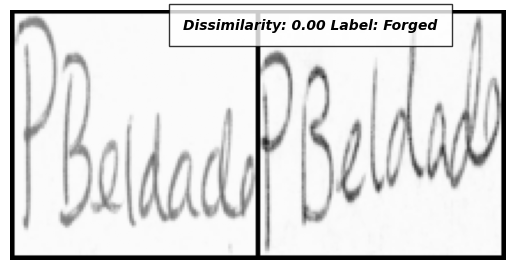

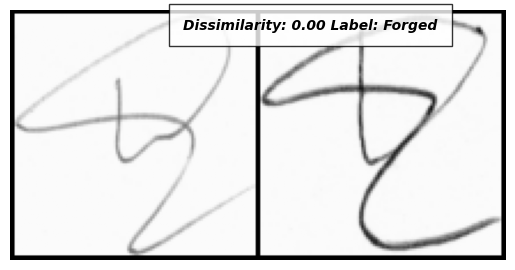

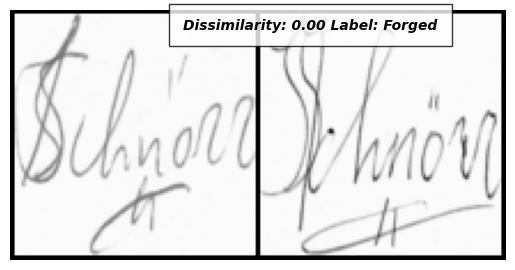

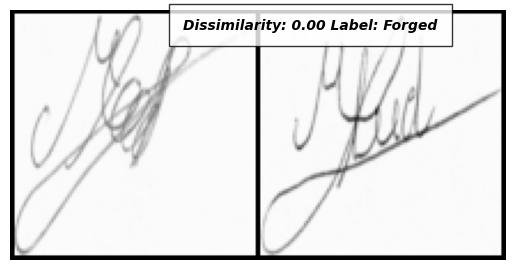

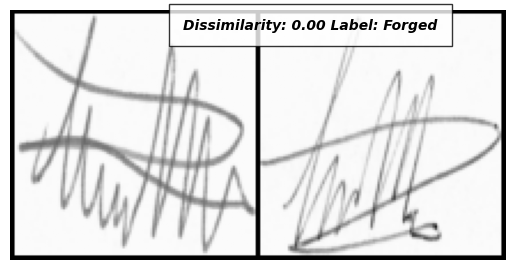

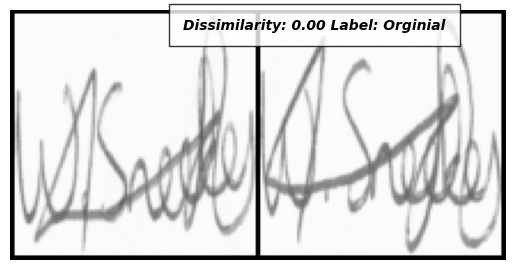

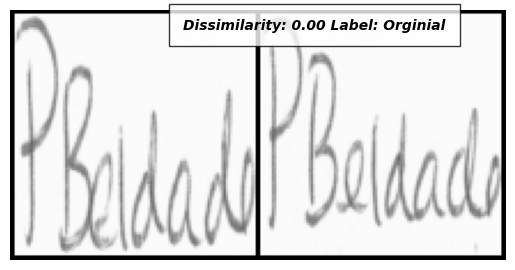

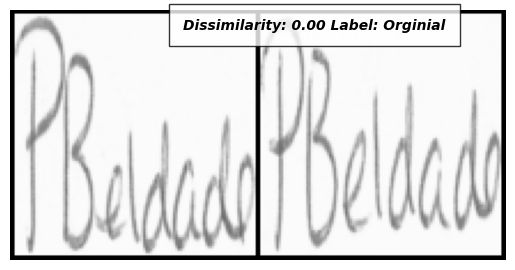

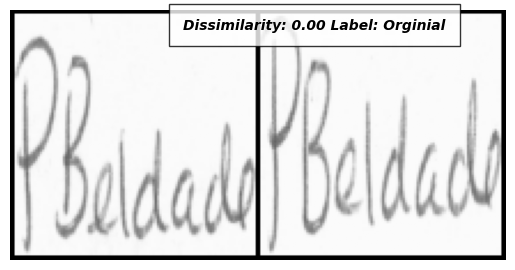

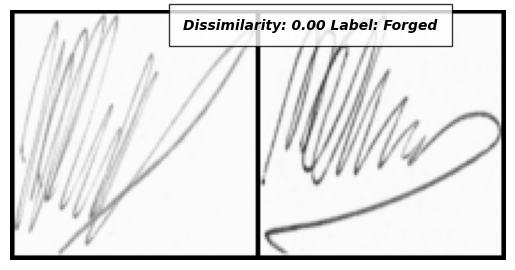

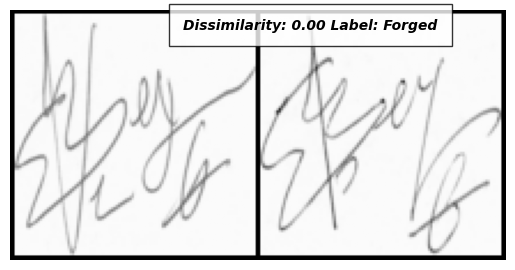

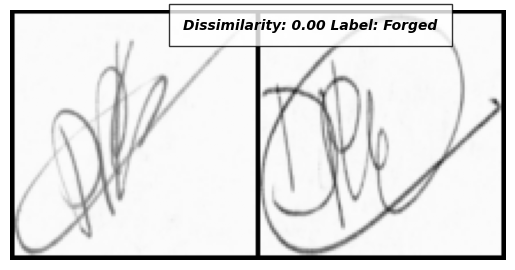

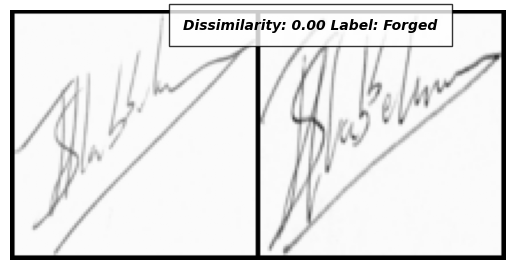

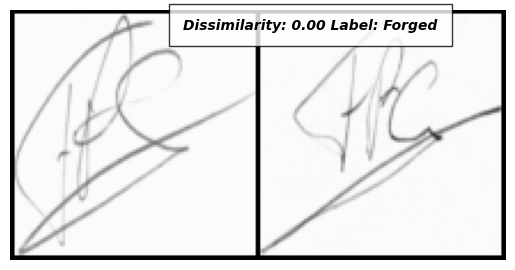

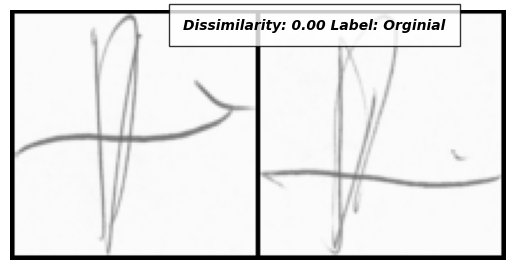

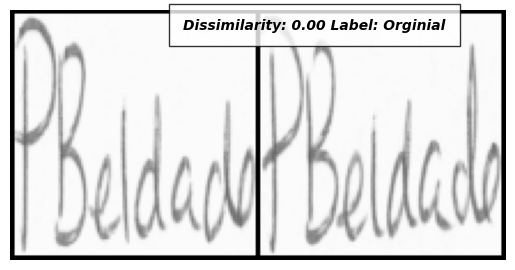

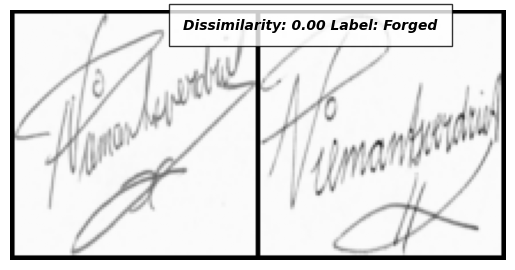

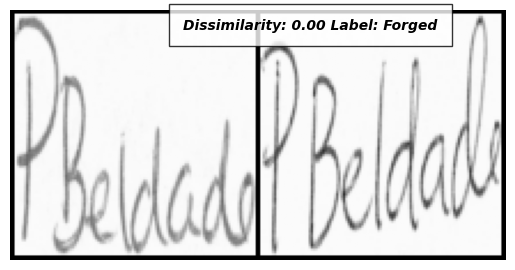

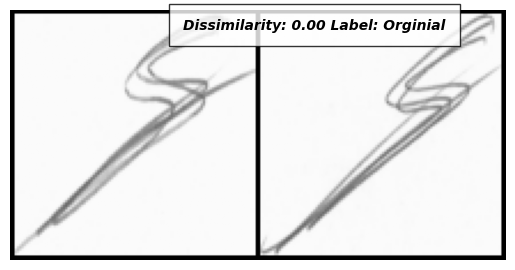

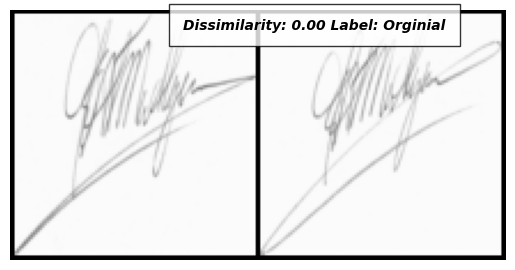

In [165]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0):
    x0, x1 , label = data
    concatenated = torch.cat((x0,x1),0)
    output1,output2 = model(x0.to(device),x1.to(device))
    eucledian_distance = F.pairwise_distance(output1, output2)
    if label==list_0:
        label="Orginial"
    else:
        label="Forged"
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
    counter=counter+1
    if counter ==20:
        break